In [3]:
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
import numpy as np

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import MapDataset
from gammapy.estimators import FluxPointsEstimator
from gammapy.makers import FoVBackgroundMaker, MapDatasetMaker, SafeMaskMaker
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    FoVBackgroundModel,
    PointSpatialModel,
    GaussianSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.utils.check import check_tutorials_setup
from gammapy.visualization import plot_npred_signal
from astroquery.simbad import Simbad
from gammapy.estimators import ExcessMapEstimator, TSMapEstimator
import yaml

from tqdm.auto import tqdm

from gammapy_tools.templates import get_config
from gammapy_tools.make_background import *
import gammapy_tools.make_background as bkg
from gammapy_tools.analysis import *

## Make 3D bkgs

In [4]:
with open('umaII.yaml', 'r') as f:
    config =yaml.safe_load(f)
config

{'io': {'from_runlist': True,
  'runlist': '/raid/romulus/swong/ED490.7/Eventdisplay_AnalysisScripts_VTS/scripts/ed_check.txt',
  'search_datastore': '/raid/romulus/dl3/ed/dl3_fullenclosure_moderate2tel/',
  'in_dir': '/raid/romulus/swong/gammapy-tools/map_test/',
  'out_dir': '/raid/romulus/swong/gammapy-tools/map_test/bkgs/',
  'results_dir': '/raid/romulus/swong/gammapy-tools/map_test/results/'},
 'config': {'njobs': 16},
 'binning': {'e_min': 0.1,
  'e_max': 30,
  'e_bins': 10,
  'off_min': 0,
  'off_max': 2.5,
  'off_bins': 25},
 'background_selection': {'nsb_diff': 1.5,
  'el_diff': 1.5,
  'az_diff': 45,
  'n_tels': 4,
  'time_max': 180,
  'smooth': True,
  'smooth_sigma': 1,
  'same_szn': True,
  'time_request': 10,
  'KL_DIV': True,
  'max_runs': True,
  'n_runs': 50,
  'store_KL': False},
 'run_selection': {'source_name': 'Ursa Major II',
  'pos_from_DL3': True,
  'offset_max': 3.5,
  'n_tel': 3,
  'el_min': 20},
 'spectrum': {'e_min': 0.2,
  'e_max': 30,
  'e_bins': 8,
  'typ

In [5]:
data_store_bkgs = DataStore.from_dir(config["io"]["in_dir"])

if config['io']['from_runlist']:
    obs_ids = np.genfromtxt(config['io']['runlist'],dtype=int,unpack=True)
    
else:
    obs_ids = data_store_bkgs.obs_ids
    
print(obs_ids)

[71084 75325 80136 85514 88055]


In [11]:
for obs in tqdm(obs_ids):
    get_background_for_run((obs,config))

  0%|          | 0/4 [00:00<?, ?it/s]

64080 used 29.812705993652344 hours for background generation


INFO:gammapy.data.data_store:Observations selected: 90 out of 90.


64081 used 43.38678741455078 hours for background generation


INFO:gammapy.data.data_store:Observations selected: 135 out of 135.
INFO:gammapy.data.data_store:Observations selected: 157 out of 157.


64083 used 40.86215591430664 hours for background generation


INFO:gammapy.data.data_store:Observations selected: 127 out of 127.


In [12]:
bkg.make_background.write_index_files(config)

# FoV analysis

In [8]:
data_store = DataStore.from_dir("/raid/romulus/swong/gammapy-tools/map_test/bkgs")

In [9]:
data_store.info()

Data store:
HDU index table:
BASE_DIR: /raid/romulus/swong/gammapy-tools/map_test/bkgs
Rows: 30
OBS_ID: 71084 -- 88055
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 5



In [12]:
source_pos = SkyCoord(132.875,63.13,unit='deg')
#source_pos = SkyCoord.from_name('Ursa Major II')
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=source_pos.ra,
    lat=source_pos.dec,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

NameResolveError: Unable to find coordinates for name 'Ursa Major II' using https://cds.unistra.fr/cgi-bin/nph-sesame/A?Ursa%20Major%20II

In [11]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])

In [17]:
energy_axis = MapAxis.from_energy_bounds(0.1, 30., 10, unit="TeV")

geom = WcsGeom.create(
    skydir=source_pos,
    binsz=0.01,
    width=(3.5, 3.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

In [18]:
energy_axis_true = MapAxis.from_energy_bounds(
    0.005, 200, 100, unit="TeV", name="energy_true"
)

In [19]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="crab-stacked"
)


In [20]:
simbad = Simbad()
simbad.reset_votable_fields()
simbad.add_votable_fields('ra', 'dec', "flux(B)", "flux(V)", "jp11")
simbad.remove_votable_fields('coordinates')

srcs_tab = simbad.query_region(source_pos, radius=1.5*u.deg)
srcs_tab = srcs_tab[srcs_tab["FLUX_B"]<6]
srcs_tab = srcs_tab[srcs_tab["FLUX_V"]!=np.ma.masked]
srcs_tab

MAIN_ID,RA,DEC,FLUX_B,FLUX_V,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",mag,mag,
object,str13,str13,float32,float32,int32
* zet Tau,05 37 38.6854,+21 08 33.158,2.84,3.03,1


In [21]:
exc = []
for star in srcs_tab:
    pos = SkyCoord(star["RA"], star["DEC"], frame="fk5", unit=(u.hourangle, u.deg))
    star = CircleSkyRegion(center=pos, radius=0.3 * u.deg)
    exc.append(star)

In [22]:
offset_max = 1.75 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-default"], offset_max=offset_max, aeff_percent=10
)

circle = CircleSkyRegion(center=source_pos, radius=0.35 * u.deg)
exc.append(circle)
exclusion_mask = ~geom.region_mask(regions=exc)
maker_fov = FoVBackgroundMaker(method="scale", exclusion_mask=exclusion_mask)

In [23]:
exclusion_mask.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [24]:
for obs in tqdm(observations):
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(stacked, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f} +/-  {dataset.background_model.spectral_model.norm.error:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

print(stacked)


  0%|          | 0/4 [00:00<?, ?it/s]

Background norm obs 64080: 0.97 +/-  0.03
Background norm obs 64081: 0.94 +/-  0.03
Background norm obs 64082: 0.85 +/-  0.03
Background norm obs 64083: 0.99 +/-  0.03
MapDataset
----------

  Name                            : crab-stacked 

  Total counts                    : 4407 
  Total background counts         : 3496.45
  Total excess counts             : 910.55

  Predicted counts                : 3496.45
  Predicted background counts     : 3496.45
  Predicted excess counts         : nan

  Exposure min                    : 1.43e-03 m2 s
  Exposure max                    : 6.45e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 1163605 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




# Get significance & counts

This needs to be run before the modelling stuff so that the source isn't subtracted!

In [6]:
estimator = ExcessMapEstimator(
    correlation_radius=0.089*u.deg,
    selection_optional=[],
    correlate_off=True
)

result = estimator.run(stacked)
result["sqrt_ts"].plot(add_cbar=True)
plt.show()

NameError: name 'stacked' is not defined

In [75]:
# ignore the insane amount of sig figs - too lazy to reformat right now

sigma = result['sqrt_ts'].get_by_coord((source_pos.ra,source_pos.dec,1*u.TeV))[0]
counts = result["counts"].get_by_coord([source_pos.ra, source_pos.dec, 1 * u.TeV])[0]
off = result["npred_background"].get_by_coord([source_pos.ra, source_pos.dec, 1 * u.TeV])[0]
print(f'significance: {sigma}, counts: {counts}, off counts: {off}')

significance: 57.777313232421875, counts: 606.0, off counts: 14.5350341796875


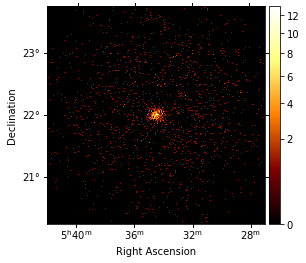

In [76]:
stacked.counts.sum_over_axes().plot(stretch="sqrt", add_cbar=True)
plt.show()

In [25]:
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-default"], offset_max=offset_max, aeff_percent=0.1
)
spatial_model = GaussianSpatialModel(
    lon_0=source_pos.ra, lat_0=source_pos.dec, sigma=0.4*u.deg, frame="icrs"
)

spectral_model = PowerLawSpectralModel(
    index=2.2,
    amplitude=4.712e-12 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

#spectral_model = ExpCutoffPowerLawSpectralModel(
#    index=2,
#    amplitude=3e-12 * u.Unit("cm-2 s-1 TeV-1"),
#    reference=1.0 * u.TeV,
#    lambda_ = 0.02/u.TeV
#)

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="crab"
)

#spatial_model.sigma.frozen = True
#spatial_model.lon_0.frozen = True
#spatial_model.lat_0.frozen = True

bkg_model = FoVBackgroundModel(dataset_name="crab-stacked")

In [26]:
stacked.models = [sky_model, bkg_model]

In [27]:
stacked.models['crab-stacked-bkg'].parameters['tilt'].frozen = False

In [28]:
stacked.models

In [ ]:
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run([stacked])

In [ ]:
print(result)

In [ ]:
stacked.models.to_parameters_table()

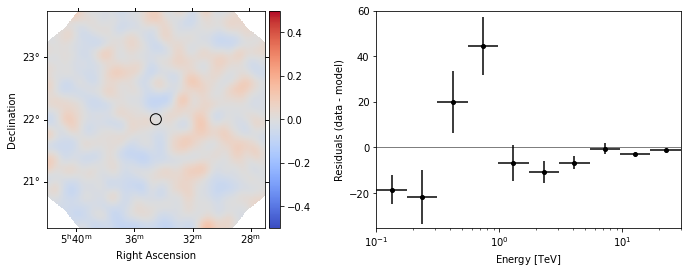

In [84]:
region = CircleSkyRegion(spatial_model.position, radius=0.089 * u.deg)
stacked.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5),
    kwargs_spectral=dict(region=region),
)
plt.show()

In [85]:
stacked.stat_sum()

44857.58706418918

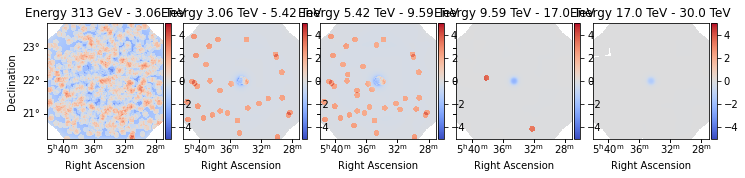

In [87]:
estimator = ExcessMapEstimator(
    correlation_radius=0.089*u.deg,
    selection_optional=[],
    energy_edges=np.linspace(0.25,30,10) * u.TeV,
)

result = estimator.run(stacked)
result["sqrt_ts"].plot_grid(
    figsize=(12, 4), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=5
)
plt.show()

# Get spectrum and compare with ED

ED results are manually input into the `ed_model`

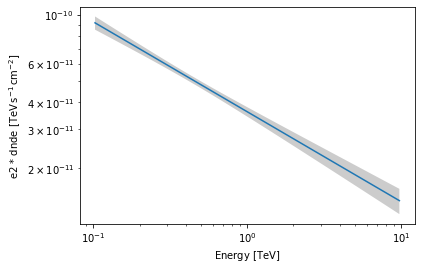

In [88]:
spec = sky_model.spectral_model

energy_bounds = [0.1, 10] * u.TeV
spec.plot(energy_bounds=energy_bounds, energy_power=2)
ax = spec.plot_error(energy_bounds=energy_bounds, energy_power=2)
plt.show()

In [89]:
ed_model = PowerLawSpectralModel(index=2.43,amplitude=3.19e-11*u.Unit("cm-2 s-1 TeV-1"))
ed_model.index.error = 0.05
ed_model.amplitude.error = 1.72e-12*u.Unit("cm-2 s-1 TeV-1")

In [ ]:
mrk501_model = PowerLawSpectralModel(index=2.45,amplitude=7.64e-12*u.Unit("cm-2 s-1 TeV-1"))
mrk501_model.index.error = 0.03
mrk501_model.amplitude.error = 2.11e-13

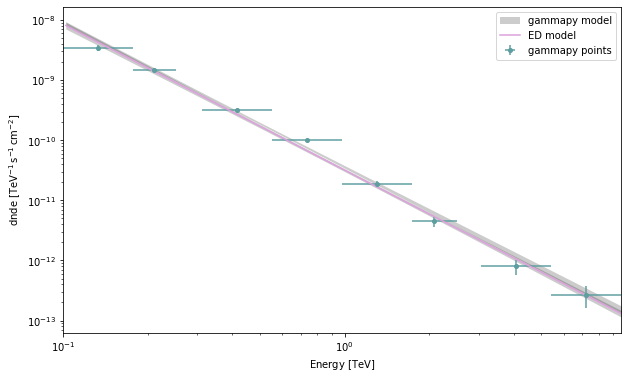

In [90]:
plt.figure(figsize=(10,6))
energy_edges = np.logspace(-1,1,11) * u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source="crab")
flux_points = fpe.run(datasets=[stacked])

ax = spec.plot_error(energy_bounds=energy_bounds, energy_power=0,color='darkseagreen', label='gammapy model')
flux_points.plot(ax=ax, energy_power=0,color='cadetblue', label='gammapy points')
ed_model.plot(energy_bounds,color='plum', label='ED model')
ed_model.plot_error(energy_bounds,color='plum')
plt.legend()
plt.show()

In [ ]:
integral_flux = spec.integral_error(0.2*u.TeV,100*u.TeV)
print(integral_flux)

In [ ]:
ed_flux = ed_model.integral_error(0.2*u.TeV,100*u.TeV)

In [ ]:
plt.errorbar(1,integral_flux[0],yerr=integral_flux[1],marker='o')
plt.errorbar(1,ed_flux[0],yerr=ed_flux[1],marker='o')

In [ ]:
(integral_flux[0].value-ed_flux[0].value)/integral_flux[0].value